In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append("..")
from modules.BatchPitNormalization import BatchPitNorm1d
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

/tmp/ipykernel_382406/490934269.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


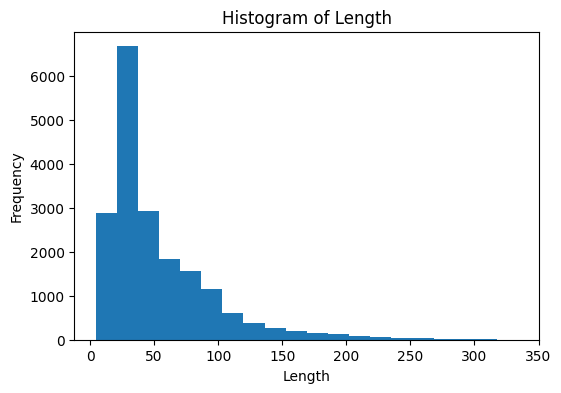

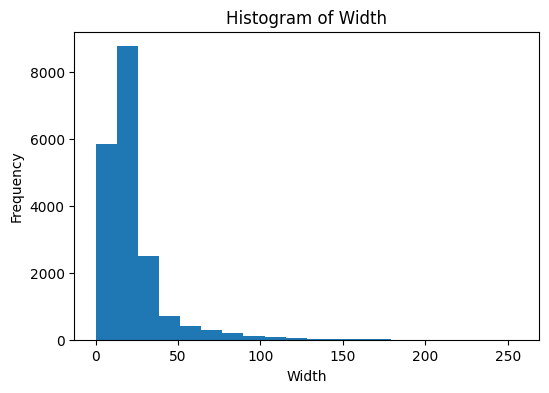

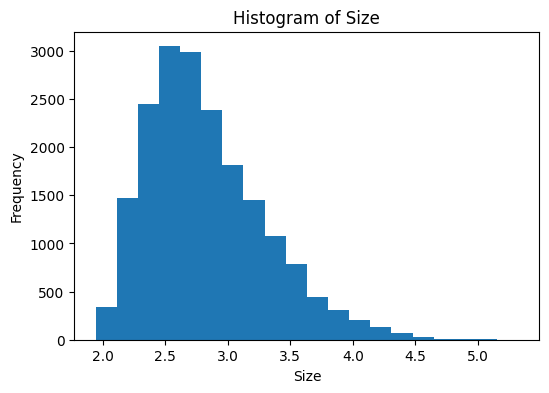

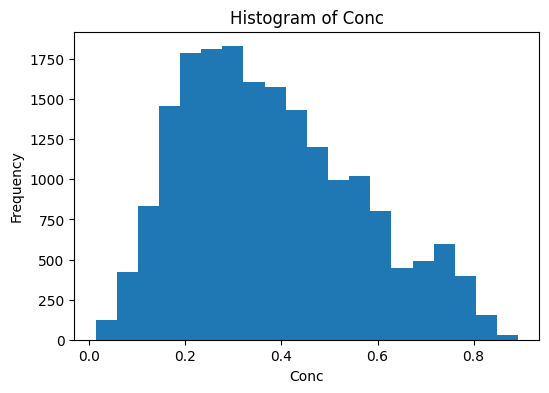

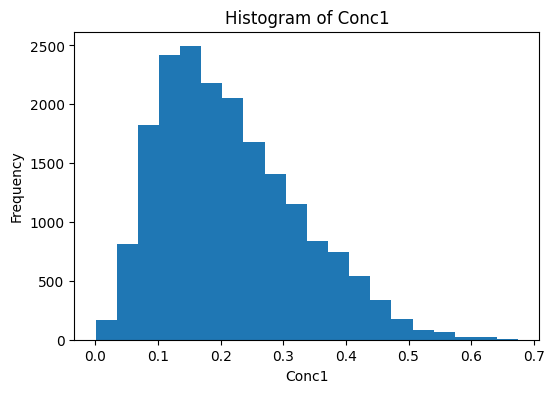

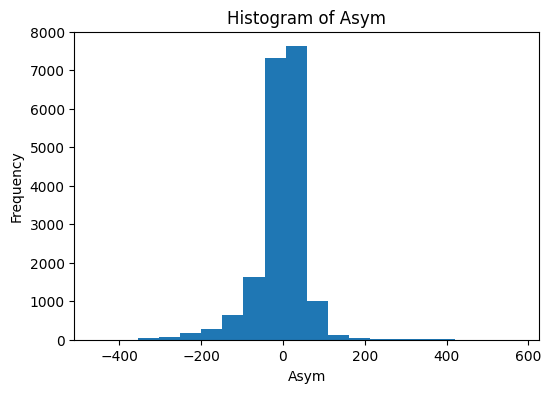

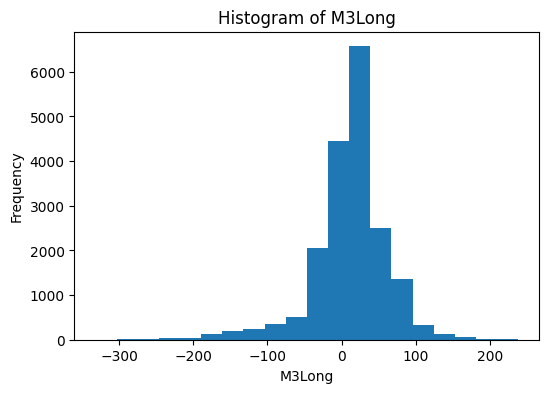

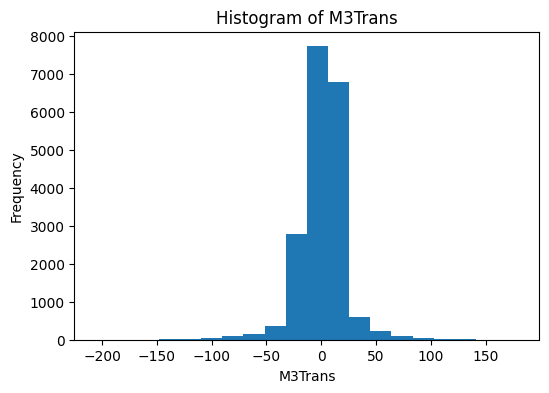

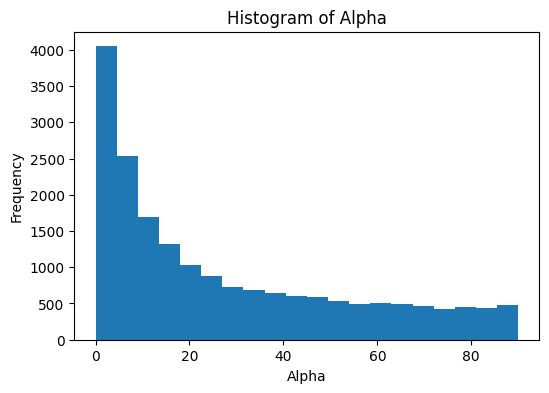

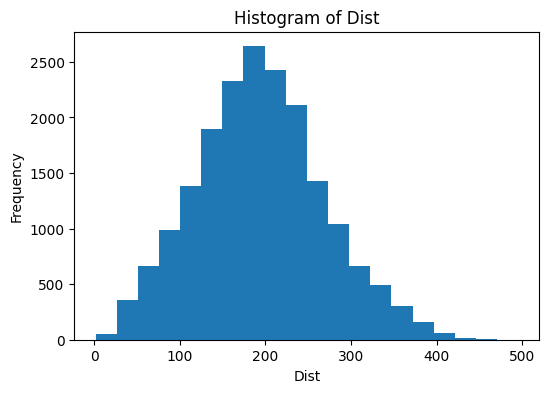

In [2]:
data = pd.read_csv("../data/magic04.data")

data.columns = ["Length", "Width", "Size", "Conc", "Conc1", "Asym", "M3Long", "M3Trans", "Alpha", "Dist", "Class"]

missing_values = data.isnull().sum()
#print(missing_values)

numeric_columns = data.select_dtypes(include=['number']).columns
for column in numeric_columns:
    # Plot the column
    plt.figure(figsize=(6, 4))
    data[column].plot(kind='hist', bins=20)  # You can choose the plot type and adjust bins as needed
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


le = LabelEncoder()
encoded_column = le.fit_transform(data["Class"])
data["Class"] = encoded_column

X = data.drop(columns=["Class"])
Y = data["Class"].to_frame()

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, shuffle = True)


scalerX = StandardScaler()
scalerY = StandardScaler()

# scale
scaler_x = scalerX.fit(X_train_raw)
scaler_y = scalerY.fit(y_train_raw)

X_train = scaler_x.transform(X_train_raw)
X_test = scaler_x.transform(X_test_raw)


y_train = scaler_y.transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_raw.values, dtype=torch.float32, device=device).reshape(-1,1)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test_raw.values, dtype=torch.float32, device=device).reshape(-1,1)


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [4]:
from torch import nn
#without bn
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [5]:
#with bn
class NeuralNetwork_bn(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork_bn, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x
    
#with bn
class NeuralNetwork_bn2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork_bn2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [6]:
#with pit
class NeuralNetwork_pit(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes,num_pit_samples,take_num_samples_when_full,normal_backtransform,trainable_bandwidth):
        super(NeuralNetwork_pit, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,trainable_bandwidths=trainable_bandwidth,normal_backtransform=normal_backtransform),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x
    
#with pit
class NeuralNetwork_pit2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes,num_pit_samples,take_num_samples_when_full,normal_backtransform,trainable_bandwidth):
        super(NeuralNetwork_pit2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,trainable_bandwidths=trainable_bandwidth,normal_backtransform=normal_backtransform),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,trainable_bandwidths=trainable_bandwidth,normal_backtransform=normal_backtransform),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

#with pit
class NeuralNetwork_pit3(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes,num_pit_samples,take_num_samples_when_full,normal_backtransform,trainable_bandwidth):
        super(NeuralNetwork_pit3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,trainable_bandwidths=trainable_bandwidth,normal_backtransform=normal_backtransform),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,trainable_bandwidths=trainable_bandwidth,normal_backtransform=normal_backtransform),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,trainable_bandwidths=trainable_bandwidth,normal_backtransform=normal_backtransform),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [7]:
def get_train_test_data(X,Y,grid_search: bool=False):
    if grid_search:
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, random_state=1)
    else:
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, shuffle = True)
    
        
    scalerX = StandardScaler()
    scalerY = StandardScaler()

    # scale
    scaler_x = scalerX.fit(X_train_raw)
    scaler_y = scalerY.fit(y_train_raw)

    X_train = scaler_x.transform(X_train_raw)
    X_test = scaler_x.transform(X_test_raw)


    y_train = scaler_y.transform(y_train_raw)
    y_test = scaler_y.transform(y_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train_raw.values, dtype=torch.float32, device=device).reshape(-1,1)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test_raw.values, dtype=torch.float32, device=device).reshape(-1,1)

    return X_train, y_train, X_test, y_test, scaler_x, scaler_y


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


def train_model(model,grid_search: bool=False):
    X_train,y_train,X_test,y_test,scaler_x,scaler_y = get_train_test_data(X,Y,grid_search)
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    lossfunction = nn.BCELoss().to(device=device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    n_epochs = 10
    batch_size = 32
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    m = nn.Sigmoid()
    for epoch in range(n_epochs):
        running_loss = 0.0
        model.to(device)
        model.train()
        for xbatch, ybatch in train_loader:
            xbatch, ybatch = xbatch.to(device), ybatch.to(device)
            y_pred = model(xbatch)

            loss = lossfunction(m(y_pred), ybatch)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            #print(loss.item())
            running_loss += loss.item()

    model.eval()
    y_pred_eval = model(X_test)
    y_pred_eval = m(y_pred_eval)
    y_pred_eval = (y_pred_eval > 0.5).float()
    y_pred_eval = y_pred_eval.detach().cpu().numpy()
    y_test_eval = y_test.detach().cpu().numpy()
    #print("accuracy:",round(100*accuracy_score(y_test_eval,np.round(y_pred_eval)),2),"%")

    #print("precision:", round(100*precision_score(y_test_eval,y_pred_eval,average="macro"),2),"%")
   # with torch.no_grad():
    #    num_correct = 0
     #   num_samples = 0
      ## for x,y in test_loader:
        #    x,y = x.to(device), y.to(device)
         ##  y_pred_eval = m(y_pred_eval)
            #y_pred_eval = y_pred_eval.detach().cpu().numpy()
            #y_test_eval = y.detach().cpu().numpy()

           # predictions = (y_pred_eval > 0.5).long()
            #num_correct += (predictions == y).sum()
            #num_samples += predictions.size(0)
            #print("accuracy:",float(num_correct)/float(num_samples)*100,"%")
            
    return accuracy_score(y_test_eval,y_pred_eval), precision_score(y_test_eval, y_pred_eval, average="macro"), f1_score(y_test_eval, y_pred_eval)


In [9]:
def grid_search():
    from itertools import product
    # Hyperparameter grid
    param_grid = {
        'num_pit_samples': [50, 100, 150, 250, 500, 1000],
        'take_num_samples_when_full': [0, 1, 2, 3, 5, 10],
        'normal_backtransform': [True, False],
        'trainable_bandwidths': [True, False]
    }
    results = np.array(("accuracy","precision","num_pit_samples","take_num_samples_when_full","normal_backtransform","trainable_bandwidth","model_id"))
    model_id = "model 3"
    hidden_size = 32
    input_size = 10
    num_classes = 1
    best_params = []

    for params in product(*param_grid.values()):
        num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params
        model = NeuralNetwork_pit3(input_size=input_size,
                                hidden_size=hidden_size,
                                num_classes=num_classes,
                                num_pit_samples=num_pit_samples,
                                normal_backtransform=normal_backtransform,
                                take_num_samples_when_full=take_num_samples_when_full,
                                trainable_bandwidth=trainable_bandwidths
                                )
        # train model
        try:
            acc_score, preci_score,f1 = train_model(model,grid_search=True)
            
            if best_params == []:
                best_params.append(acc_score)
                best_params.append(params)
            elif acc_score > best_params[0]:
                best_params[0] = acc_score
                best_params[1] = params
            grid_res = np.array((acc_score,preci_score, params[0],params[1],params[2],params[3],model_id))
            results = np.vstack((results,grid_res))

            print(best_params, params, acc_score)
        except:
            print("error")
            return results

    print("best!!! ", best_params)
    return results


results_grid = grid_search()

# convert array into dataframe 
DF = pd.DataFrame(results_grid) 
  
# save the dataframe as a csv file 
DF.to_csv("magic_model3.csv")

[0.8678583946722748, (50, 0, True, True)] (50, 0, True, True) 0.8678583946722748
[0.8692604276200491, (50, 0, True, False)] (50, 0, True, False) 0.8692604276200491
[0.8692604276200491, (50, 0, True, False)] (50, 0, False, True) 0.8647038205397827
[0.8692604276200491, (50, 0, True, False)] (50, 0, False, False) 0.8634770417104802
[0.8692604276200491, (50, 0, True, False)] (50, 1, True, True) 0.8601472134595163
[0.8692604276200491, (50, 0, True, False)] (50, 1, True, False) 0.8622502628811777
[0.8692604276200491, (50, 0, True, False)] (50, 1, False, True) 0.8329828250963898
[0.8692604276200491, (50, 0, True, False)] (50, 1, False, False) 0.8606729758149316
[0.8692604276200491, (50, 0, True, False)] (50, 2, True, True) 0.8594461969856292
[0.8692604276200491, (50, 0, True, False)] (50, 2, True, False) 0.8659305993690851
[0.8692604276200491, (50, 0, True, False)] (50, 2, False, True) 0.8077462320364529
[0.8692604276200491, (50, 0, True, False)] (50, 2, False, False) 0.8575184016824395
[0.86

In [10]:
model_1 = NeuralNetwork(10,32,1)
model_2 = NeuralNetwork_bn(10,32,1)
model_3 = NeuralNetwork_bn2(10,32,1)
model_4 = NeuralNetwork_pit(input_size = 10,
                            hidden_size = 32,
                            num_classes = 1,
                            num_pit_samples=1000,
                            take_num_samples_when_full=1,
                            normal_backtransform=True,
                            trainable_bandwidth=True)
model_5 = NeuralNetwork_pit2(input_size = 10,
                            hidden_size = 32,
                            num_classes = 1,
                            num_pit_samples=1000,
                            take_num_samples_when_full=1,
                            normal_backtransform=True,
                            trainable_bandwidth=True)
model_6 = NeuralNetwork_pit3(input_size = 10,
                            hidden_size = 32,
                            num_classes = 1,
                            num_pit_samples=1000,
                            take_num_samples_when_full=1,
                            normal_backtransform=True,
                            trainable_bandwidth=True)

ac1_l,pr1_l = [],[]
ac2_l,pr2_l = [],[]
ac3_l,pr3_l = [],[]
ac4_l,pr4_l = [],[]
ac5_l,pr5_l = [],[]
ac6_l,pr6_l = [],[]
for i in range(7):
    ac1,pr1 = train_model(model_1)
    ac2,pr2 = train_model(model_2)
    ac3,pr3 = train_model(model_3)
    ac4,pr4 = train_model(model_4)
    ac5,pr5 = train_model(model_5)
    ac6,pr6 = train_model(model_5)

    ac1_l.append(ac1)
    pr1_l.append(pr1)
    ac2_l.append(ac2)
    pr2_l.append(pr2)
    ac3_l.append(ac3)
    pr3_l.append(pr3)
    ac4_l.append(ac4)
    pr4_l.append(pr4)
    ac5_l.append(ac5)
    pr5_l.append(pr5)
    ac6_l.append(ac6)
    pr6_l.append(pr6)


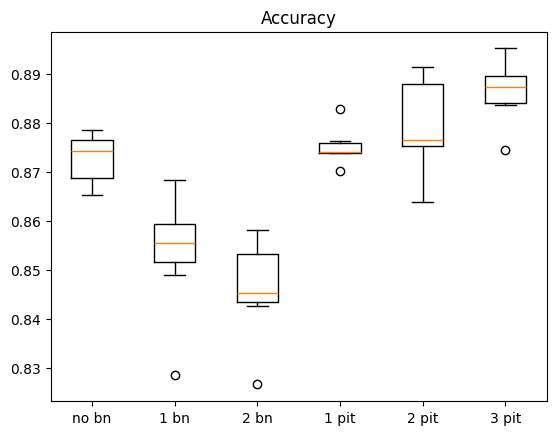

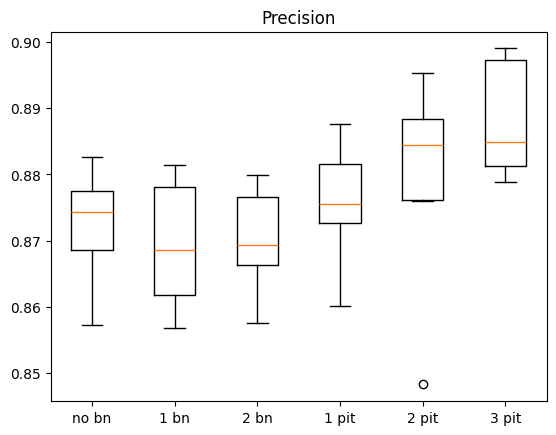

In [11]:
plt.boxplot([ac1_l,ac2_l,ac3_l,ac4_l,ac5_l,ac6_l],labels=["no bn","1 bn", "2 bn", "1 pit","2 pit","3 pit"])
plt.title("Accuracy")
plt.figure()
plt.boxplot([pr1_l,pr2_l,pr3_l,pr4_l,pr5_l,pr6_l],labels=["no bn","1 bn", "2 bn", "1 pit","2 pit","3 pit"])
plt.title("Precision")
plt.show()